In [14]:
import cv2
import numpy as np
from pynq import Overlay
from pynq import MMIO
import time
import matplotlib.pyplot as plt

# Path to the tile
tile_path = "output_images_cycle_9/tile_4.jpg"

# Read the image tile (BGR format by default)
tile_img = cv2.imread(tile_path)

# Convert from BGR to RGB
tile_img_rgb = cv2.cvtColor(tile_img, cv2.COLOR_BGR2RGB)

# Check if the image was loaded correctly
if tile_img_rgb is None:
    print(f"Error: Unable to load tile image from {tile_path}")
    exit(1)

padded_array = np.zeros((84, 84, 3), dtype=int)
padded_array[2:82, 2:82, :] = tile_img_rgb[:, :, :]

# Set tile size (should match the tile's dimensions)
tile_size = 84  # Assuming the tile is square

# Load overlay
overlay = Overlay('PSPL_LED.bit')

# Define memory-mapped I/O base addresses
BRAM0_ADDR_BASE = 0x40000000
BRAM_ADDR_RANGE = 0x8000  # 32 KB

# Define GPIO base address and offsets
GPIO_BASE_ADDR = 0x81200000  # Base address for PS GPIO
GPIO_DATA_OFFSET = 0x40      # Data Register
GPIO_DIRM_OFFSET = 0x204     # Direction Mode Register
GPIO_OEN_OFFSET = 0x208      # Output Enable Register
GPIO_PIN_MASK = 1 << 0       # Using GPIO 0 (MIO 0)

# Create MMIO objects
bram0_obj = MMIO(BRAM0_ADDR_BASE, BRAM_ADDR_RANGE)
gpio_obj = MMIO(GPIO_BASE_ADDR, 0x1000)

# Configure GPIO 0 as an output
gpio_obj.write(GPIO_DIRM_OFFSET, gpio_obj.read(GPIO_DIRM_OFFSET) | GPIO_PIN_MASK)
gpio_obj.write(GPIO_OEN_OFFSET, gpio_obj.read(GPIO_OEN_OFFSET) | GPIO_PIN_MASK)

def send_data_to_bram(bram0_obj, padded_array, tile_size):
    """
    Sends image data to BRAM and sets a GPIO pin HIGH while transferring.
    """
    process_start = time.time()

    # Set GPIO HIGH (indicating data transfer is ongoing)
    gpio_obj.write(GPIO_DATA_OFFSET, gpio_obj.read(GPIO_DATA_OFFSET) | GPIO_PIN_MASK)

    for i in range(tile_size):
        for j in range(tile_size):
            offset = (i * tile_size + j) * 4  
            
            r = int(padded_array[i, j, 0])
            g = int(padded_array[i, j, 1])
            b = int(padded_array[i, j, 2])
            
            packed_data = (0x00 << 24) | (r << 16) | (g << 8) | b

            # Write data to BRAM0
            bram0_obj.write(offset, packed_data)

    # Set GPIO LOW (indicating data transfer is done)
    gpio_obj.write(GPIO_DATA_OFFSET, gpio_obj.read(GPIO_DATA_OFFSET) & ~GPIO_PIN_MASK)

    return time.time() - process_start


def read_bram_full_data(bram1_obj, tile_size):
    """
    Read full data from BRAM and reconstruct RGB channels.
    """
    R_bram = np.zeros((tile_size, tile_size), dtype=np.uint8)
    G_bram = np.zeros((tile_size, tile_size), dtype=np.uint8)
    B_bram = np.zeros((tile_size, tile_size), dtype=np.uint8)
    
    for i in range(tile_size):
        for j in range(tile_size):
            offset = (i * tile_size + j) * 4  # 4 bytes per pixel (32 bits)
            
            # Read 32-bit data from BRAM (Low and High 16 bits for each channel)
            read_value = bram1_obj.read(offset)  # 32-bit value
            #if read_value != 0:
            #print(f"Non-zero value at {hex(offset)}: {hex(read_value)}")

            # Extract R, G, B channels from the 32-bit data
            r = (read_value >> 16) & 0xFF  # Extract Red (bits 16-23)
            g = (read_value >> 8) & 0xFF   # Extract Green (bits 8-15)
            b = read_value & 0xFF          # Extract Blue (bits 0-7)

            R_bram[i, j] = r
            G_bram[i, j] = g
            B_bram[i, j] = b

    # Reconstruct the image from BRAM channels
    reconstructed_image = np.stack([R_bram, G_bram, B_bram], axis=-1)

    return R_bram, G_bram, B_bram, reconstructed_image

# Send data to BRAM
bram_time = send_data_to_bram(bram0_obj, padded_array, tile_size)
print(f"Time to send data to BRAM: {bram_time:.6f} seconds")


Time to send data to BRAM: 0.275386 seconds


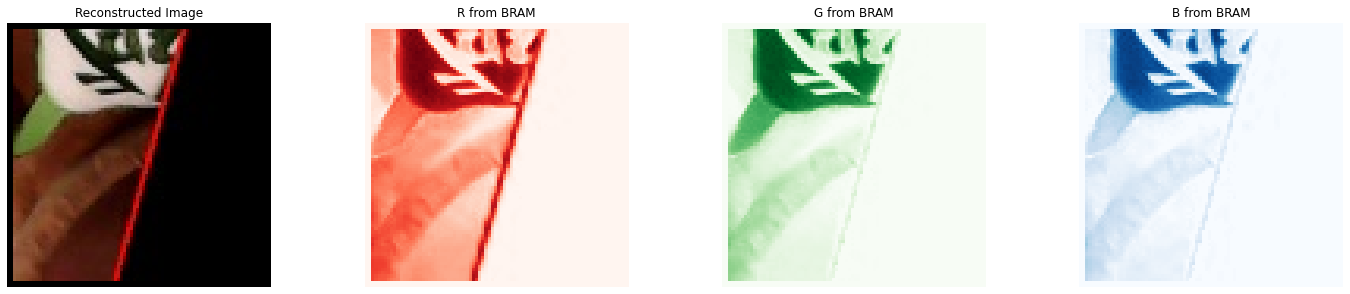

In [13]:
R_bram, G_bram, B_bram, reconstructed_image = read_bram_full_data(bram0_obj, tile_size)

plt.figure(figsize=(20, 8))

# Display Reconstructed Image
plt.subplot(2, 4, 5)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')

# Display R channel from BRAM
plt.subplot(2, 4, 6)
plt.imshow(R_bram, cmap='Reds')
plt.title("R from BRAM")
plt.axis('off')

# Display G channel from BRAM
plt.subplot(2, 4, 7)
plt.imshow(G_bram, cmap='Greens')
plt.title("G from BRAM")
plt.axis('off')

# Display B channel from BRAM
plt.subplot(2, 4, 8)
plt.imshow(B_bram, cmap='Blues')
plt.title("B from BRAM")
plt.axis('off')

plt.tight_layout()
plt.show()